## 1 Import Data

In [33]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')# delete normal warnings to make code more clean
df = pd.read_excel("online_data.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 2 Data Cleaning

In [34]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date #change string to datetime
df = df[pd.notnull(df['CustomerID'])] #delete null values for customerId
df = df[(df['Quantity']>0)]  #delete quantity<0
df = df[(df['UnitPrice']>0)] #delete unitprice<0 
#why negative for quantitiy and unitprice? the free sample given away to customers
df['Sales'] = df['Quantity'] * df['UnitPrice'] #generate a new variable: sales
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales'] # select three variables that we are most caring
df = df[cols_of_interest]
print(df.head())
print(df.head())
print(df['CustomerID'].nunique())#how many unique customerID

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
4338


## 3. Modeling using Lifetime Package

### 3.1 EDA

In [35]:
import sys
!{sys.executable} -m pip install lifetimes

In [36]:
from lifetimes.plotting import * # visualization
from lifetimes.utils import * # transform
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
#transfer into dataframe that has "customer_ID" as primary key and get info for frequency, recency and monetary value
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


         frequency      recency            T  monetary_value
count  4338.000000  4338.000000  4338.000000     4338.000000
mean      2.864223   130.771554   222.831028      307.028848
std       5.949000   132.210509   117.854570     2612.749850
min       0.000000     0.000000     0.000000        0.000000
25%       0.000000     0.000000   112.000000        0.000000
50%       1.000000    93.000000   248.000000      177.064773
75%       3.000000   252.000000   326.000000      360.162500
max     131.000000   373.000000   373.000000   168469.600000
0.35684647302904565


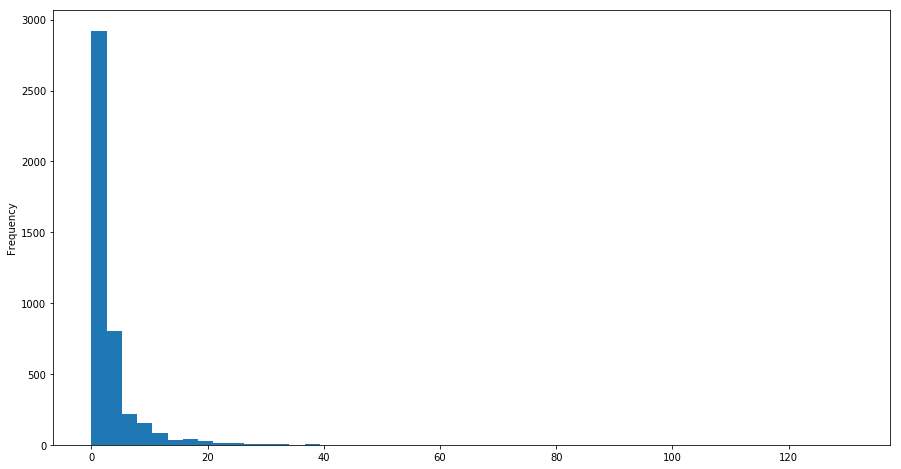

In [37]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0)#length and width

data['frequency'].plot(kind='hist', bins=50)#frequency distribution
print(data.describe())
print(sum(data['frequency'] == 0)/float(len(data)))

In [38]:
# Insight 1
# No repeated customer when transforming as count is the same as unique customer ID above
# Right skew: maximum frequency is 131, the average frequency is around 3 ( low -frequency)
# recency: around 130 and T around 222 ( ususally half year)
# around 36% people are 0 frequency--a little high


### 3.2 Explore Customer Intimacy using BG/NBD model

In [39]:
?BetaGeoFitter

In [40]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0) # penalty, to avoid overfitting, between 0.001-0.1
bgf.fit(data['frequency'], data['recency'], data['T']) #fit models and make predictions
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.91, b: 6.75, r: 0.83>


#### 3.2.1 Visualize Frequency/Receny Matrix

In [41]:
#1.the probability that the customer will purchase in the future time

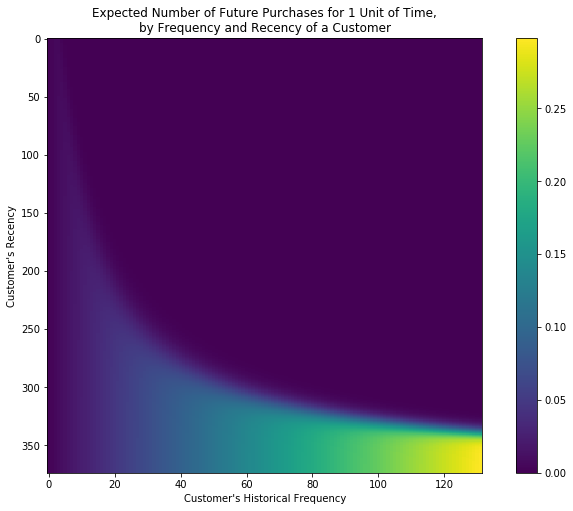

In [42]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf) 

In [43]:
#2. Probability the customer is alive or not

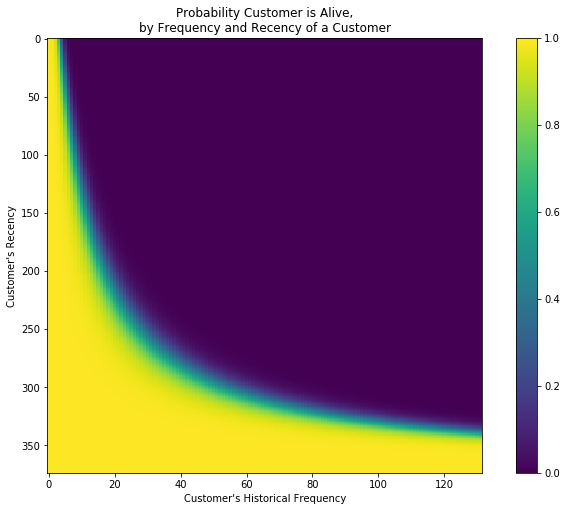

In [44]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

#### 3.2.2 Predict the Probability for Purchasing in a Certain Period of Time

In [45]:
t = 1 # the probability that the customer will purchase in next 1 day
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.200998
15311.0,89.0,373.0,373.0,677.729438,0.203263
17841.0,111.0,372.0,373.0,364.452162,0.253045
12748.0,112.0,373.0,373.0,301.024821,0.255310
14911.0,131.0,372.0,373.0,1093.661679,0.298303


In [46]:
t = 30 # in next 30 days( for some industries that customers not purchase so much)
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)


,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,6.029322
15311.0,89.0,373.0,373.0,677.729438,6.097251
17841.0,111.0,372.0,373.0,364.452162,7.590548
12748.0,112.0,373.0,373.0,301.024821,7.658492
14911.0,131.0,372.0,373.0,1093.661679,8.948135


In [ ]:
 # monetary: based on this, the company can decide how much they need to invest
# right frequency, content for advertising/communication with customers

#### 3.2.3 Model Evaluation

In [ ]:
# 1. split dataset as training and testing and make comparison between prediction and testing

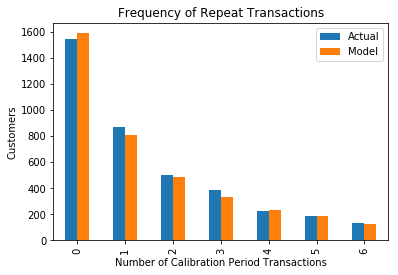

In [15]:
from lifetimes.plotting import plot_period_transactions#actual and model comparison
plot_period_transactions(bgf)

In [ ]:
# We see the result is close, especially when the transactions is 5 times
# 0 transaction , a lot of people here
# each number of transaction increased, there are around 100 or 200 people decrease

In [ ]:
#2. According to specific time to manually split dataset

In [16]:
from lifetimes.utils import calibration_and_holdout_data # split dataset as training and validation
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                  184  
12347.0                  184  
12348.0                  184  
12350.0                  184  
12352.0                  184  


In [ ]:
# 3. Using RMSE

In [17]:
import numpy as np
from matplotlib import *

rmse_train_count = (summary_cal_holdout['frequency_holdout'] - summary_cal_holdout['frequency_cal']).apply(lambda x : x*x)
rmse_train_count = np.sqrt(rmse_train_count.sum()/len(data))
print('RMSE =', rmse_train_count)

RMSE = 1.9693946899759547


#### 3.2.4 Predict Customer Alive Probability

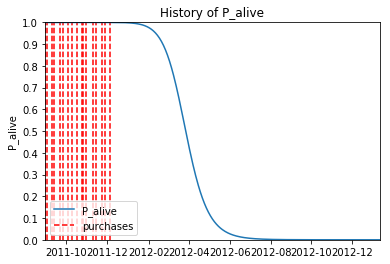

In [20]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
#id = 13093 # long time, low frequency, slowly decreased
id=14096 # short time, high frequency, quickly decreased
# id= 15061 # every interval, start to purchase, high p not decrease
#choose customer id
days_since_birth = 500
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')
#y-axis: the p that the customers are still alive

### 3.3 Predict Customer Purchase Power using GAMMA-GAMMA

In [47]:
returning_customers_summary = data[data['frequency']>0] # filter those only have 1 purchase
print(returning_customers_summary.head())
print(len(returning_customers_summary))


            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.469643
12348.0           3.0    283.0  358.0      301.480000             0.268666
12352.0           6.0    260.0  296.0      368.256667             0.560850
12356.0           2.0    303.0  325.0      269.905000             0.215146
12358.0           1.0    149.0  150.0      683.200000             0.250170
2790


In [48]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)#avoid overfitting by adusting penalty, default value is zero
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.89>


In [49]:
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,6.029322
15311.0,89.0,373.0,373.0,677.729438,6.097251
17841.0,111.0,372.0,373.0,364.452162,7.590548
12748.0,112.0,373.0,373.0,301.024821,7.658492
14911.0,131.0,372.0,373.0,1093.661679,8.948135


In [50]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).sort_values().tail(10))#calculate the average profit for customer

CustomerID
14088.0     3570.204225
14096.0     3823.332098
12536.0     4067.704214
16684.0     4107.562364
14646.0     6213.190876
17450.0     7104.927026
12415.0     7323.629188
18102.0     8951.640509
15749.0    10170.076618
16446.0    78026.825868
dtype: float64


In [ ]:
# Make prediction for customers's purchase frequency in next T based on BGF,EG

In [51]:
t = 90
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

1.4087355398553587

In [52]:
print(416.94 * 1.4054323465114449)

585.9809625544818


In [59]:
ggdf=pd.DataFrame({'CustomerID':gg.index, 'average_profit':gg.values})

In [60]:
ggdf.head()

,CustomerID,average_profit
0,12346.0,416.946028
1,12347.0,569.978836
2,12348.0,333.784235
3,12349.0,416.946028
4,12350.0,416.946028


In [55]:
data.head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12346.0,0.0,0.0,325.0,0.000000,0.062948
12347.0,6.0,365.0,367.0,599.701667,0.469643
12348.0,3.0,283.0,358.0,301.480000,0.268666
12349.0,0.0,0.0,18.0,0.000000,0.285282
12350.0,0.0,0.0,310.0,0.000000,0.065439


In [61]:
result = pd.merge(ggdf,
                 data,
                 on='CustomerID')
result.head()

,CustomerID,average_profit,frequency,recency,T,monetary_value,predicted_purchases
0,12346.0,416.946028,0.0,0.0,325.0,0.000000,0.062948
1,12347.0,569.978836,6.0,365.0,367.0,599.701667,0.469643
2,12348.0,333.784235,3.0,283.0,358.0,301.480000,0.268666
3,12349.0,416.946028,0.0,0.0,18.0,0.000000,0.285282
4,12350.0,416.946028,0.0,0.0,310.0,0.000000,0.065439


In [62]:
#generate customer_lifetime_value in next T( 90 days)
result["cust_value_ninety"]=result["average_profit"]*result["predicted_purchases"]

In [63]:
result["cust_value_ninety"].sum()

768900.935620018

In [65]:
result.head()

,CustomerID,average_profit,frequency,recency,T,monetary_value,predicted_purchases,cust_value_ninety
0,12346.0,416.946028,0.0,0.0,325.0,0.000000,0.062948,26.245757
1,12347.0,569.978836,6.0,365.0,367.0,599.701667,0.469643,267.686554
2,12348.0,333.784235,3.0,283.0,358.0,301.480000,0.268666,89.676604
3,12349.0,416.946028,0.0,0.0,18.0,0.000000,0.285282,118.947030
4,12350.0,416.946028,0.0,0.0,310.0,0.000000,0.065439,27.284730
